In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import glob as gb
import cv2
import keras

from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
code = {'Tomato___Bacterial_spot':0 ,'Tomato___Early_blight':1,'Tomato___Late_blight':2,'Tomato___Leaf_Mold':3,'Tomato___Septoria_leaf_spot':4,'Tomato___Spider_mites Two-spotted_spider_mite':5 , 'Tomato___Target_Spot':6 ,'Tomato___Tomato_Yellow_Leaf_Curl_Virus':7 , 'Tomato___Tomato_mosaic_virus':8 ,'Tomato___healthy':9  }

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [3]:
path='/kaggle/input/plantvillage-dataset/color/'

In [4]:
s = 128
X = []
y = []
for folder in  os.listdir(path) :
    if(folder.startswith("Tomato")):
        files = gb.glob(pathname= str( path  + folder + '/*.JPG'))
        print(folder)
        for file in files: 
            image = cv2.imread(file)
            image_array = cv2.resize(image , (s,s))
            image=image/255
            X.append(list(image_array))
            y.append(folder)

print(f'we have {len(X)} items in X ')

Tomato___Late_blight
Tomato___healthy
Tomato___Early_blight
Tomato___Septoria_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Bacterial_spot
Tomato___Target_Spot
Tomato___Tomato_mosaic_virus
Tomato___Leaf_Mold
Tomato___Spider_mites Two-spotted_spider_mite
we have 18006 items in X 


In [5]:
y = np.array(y).reshape(-1, 1)

In [6]:
from sklearn.preprocessing import OneHotEncoder
one=OneHotEncoder()
y=one.fit_transform(y).toarray()

In [7]:
X = np.array(X)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  shuffle=True, random_state=42)

In [9]:
del X
del y

In [10]:
from sklearn.model_selection import train_test_split
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5,  shuffle=True, random_state=42)

In [11]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x
class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [12]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [13]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [14]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


In [15]:
class SwinTransformerCreate(keras.layers.Layer):
    def __init__(self,dim,num_patch,num_heads,window_size,
                 num_mlp,qkv_bias,dropout_rate,patch_size,num_patch_x,num_patch_y, 
                 embed_dim,num_classes,shift_size=0):
        
        super(SwinTransformerCreate,self).__init__()
        self.dim=dim
        self.num_patch=num_patch
        self.num_heads=num_heads
        self.window_size=window_size
        self.num_mlp=num_mlp
        self.num_mlp=num_mlp
        self.qkv_bias=qkv_bias
        self.dropout_rate=dropout_rate
        self.patch_size=patch_size
        self.num_patch_x=num_patch_x
        self.num_patch_y=num_patch_y
        self.embed_dim=embed_dim
        self.num_classes=num_classes
        self.shift_size=shift_size

        self.patch_extract=PatchExtract(patch_size=self.patch_size)
        self.patch_emped=PatchEmbedding(self.num_patch_x * self.num_patch_y, self.embed_dim)
        self.swin1= SwinTransformer(dim=self.dim,
                                    num_patch=(self.num_patch_x, self.num_patch_y),
                                    num_heads=self.num_heads,
                                    window_size=self.window_size,shift_size=0,
                                    num_mlp=self.num_mlp,qkv_bias=self.qkv_bias,
                                    dropout_rate=self.dropout_rate)
        self.swin2= SwinTransformer(dim=self.dim,
                                    num_patch=(self.num_patch_x, self.num_patch_y),
                                    num_heads=self.num_heads,
                                    window_size=self.window_size,
                                    num_mlp=self.num_mlp,qkv_bias=self.qkv_bias,
                                    dropout_rate=self.dropout_rate)
        self.patchmerg=PatchMerging((self.num_patch_x, self.num_patch_y), embed_dim=self.embed_dim)
        self.glop= layers.GlobalAveragePooling1D()
        self.out = layers.Dense(self.num_classes, activation="softmax")
    
    def call(self,x):
        x = self.patch_extract(x)
        x = self.patch_emped(x)
        x = self.swin1(x)
        x = self.swin2(x)
        x = self.patchmerg(x)
        x = self.glop(x)
        x = self.out(x)
        return x

In [16]:
input_shape=(128,128,3)
num_classes=10
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 128  # Initial image size
num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]
num_patch=(num_patch_x, num_patch_y)

In [17]:
inputs = layers.Input(shape=input_shape)
model=SwinTransformerCreate(patch_size=patch_size,num_heads=num_heads,embed_dim=embed_dim,
                           num_mlp=num_mlp,qkv_bias=qkv_bias,window_size=window_size,
                           shift_size=shift_size,num_patch_x=num_patch_x,num_patch_y=num_patch_y,
                           num_classes=num_classes,dropout_rate=dropout_rate,dim=embed_dim,
                           num_patch=num_patch)(inputs)
model = keras.Model(inputs=inputs, outputs=model)

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [19]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),optimizer='adam',
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
)

history = model.fit(X_train,y_train,validation_data=(X_valid,y_valid), 
                    epochs=50,callbacks=[callback],batch_size=128,
                    verbose=1 )

Epoch 1/50
113/113 [==============================] - 64s 532ms/step - loss: 24.0615 - accuracy: 0.2770 - val_loss: 9.6461 - val_accuracy: 0.2865
Epoch 2/50
113/113 [==============================] - 59s 526ms/step - loss: 7.4431 - accuracy: 0.3110 - val_loss: 9.5154 - val_accuracy: 0.3765
Epoch 3/50
113/113 [==============================] - 59s 526ms/step - loss: 6.4061 - accuracy: 0.3357 - val_loss: 3.8230 - val_accuracy: 0.3792
Epoch 4/50
113/113 [==============================] - 59s 526ms/step - loss: 4.3652 - accuracy: 0.3711 - val_loss: 5.0109 - val_accuracy: 0.4381
Epoch 5/50
113/113 [==============================] - 59s 526ms/step - loss: 4.4204 - accuracy: 0.3861 - val_loss: 2.0487 - val_accuracy: 0.5269
Epoch 6/50
113/113 [==============================] - 59s 526ms/step - loss: 1.5892 - accuracy: 0.5206 - val_loss: 1.5803 - val_accuracy: 0.5458
Epoch 7/50
113/113 [==============================] - 59s 525ms/step - loss: 1.9543 - accuracy: 0.5044 - val_loss: 1.3286 - val_a

In [20]:
from tensorflow.keras.utils import to_categorical
y_pred = model.predict(X_test)
y_pred2= to_categorical(np.argmax(y_pred, axis=1), 10)

# Using it in AUC
y_pred1=(np.argmax(y_pred, axis=1))
y_test1=(np.argmax(y_test, axis=1))

In [21]:
# check whether the model is best fit for the given problem and corresponding data , Evaluate the model on the test data
def evaluate_model(X_test , y_test):
    results = model.evaluate(X_test, y_test, batch_size=32)
    return results

In [22]:
# Computing the Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
def Accuracy(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    return AccScore

In [23]:
#Computing the Precision metric (Some times called Specificity): #(True Positives / float(True Positives + False Posivites))  
def macro_precision(y_test , y_pred):
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    return PrecisionScore

In [24]:
#Computing the Recall Score : (Some times called Sensitivity) (TP / float(TP + FN))   1 / 1+2  
def macro_recall(y_test , y_pred):
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    return  RecallScore

In [25]:
#Computing the F1 Score  : 2 * (precision * recall) / (precision + recall)
def macro_F1Score(y_test , y_pred):
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return F1Score

In [26]:
from sklearn.metrics import roc_auc_score

# Calculating Area under the curve
def AUC(actual_class, pred_class, average = "micro"):
    
    #Making a set of all the unique classes 
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #Making a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [27]:
print("***** Model Evaluations Details ******** \n")
print("Test loss, Test acc : " , evaluate_model(X_test , y_test)) 
print("******************************")
print("Accuracy  : " , Accuracy(y_test , y_pred2)) 
print("******************************")
print("Precision Score is : " , macro_precision(y_test , y_pred2))
print("******************************")
print("Recall Scores is : " , macro_recall(y_test , y_pred2))
print("******************************")
print('F1 Score is : ', macro_F1Score(y_test , y_pred2))
print("******************************")
print('AUC Score is : ' , AUC(y_test1, y_pred1))

***** Model Evaluations Details ******** 

57/57 [==============================] - 3s 49ms/step - loss: 0.2536 - accuracy: 0.9189
Test loss, Test acc :  [0.2535690367221832, 0.9189339280128479]
******************************
Accuracy  :  0.9167129372570794
******************************
Precision Score is :  0.9006218059458521
******************************
Recall Scores is :  0.910835844714537
******************************
F1 Score is :  0.9035954444588443
******************************
AUC Score is :  {0: 0.9456033950115443, 1: 0.9175973971502871, 2: 0.9498252148061027, 3: 0.9670917317976142, 4: 0.9175226313701447, 5: 0.8990510529903492, 6: 0.9563381184311714, 7: 0.9731633694356547, 8: 0.9833059959905232, 9: 0.9978710462287105}


In [28]:
def plot_roc_curve(y_test,y_pred):
    n_classes=10
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

    colors = cycle(["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#666600'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

In [29]:
def Acc_Loss_Graph(history):
    # converting hsitory to dataframe
    pd.DataFrame(history.history)

    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')

    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [30]:
def Confusion_Matrix(y_test , y_pred):
    fig, ax = plt.subplots(figsize=(10,10))

    #cnf_matrix = confusion_matrix()
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=code.keys(),ax=ax,xticks_rotation='vertical'
                                                  ,cmap="Blues")

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.style.library['seaborn-whitegrid']

RcParams({'axes.axisbelow': True,
          'axes.edgecolor': '.8',
          'axes.facecolor': 'white',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 1.0,
          'figure.facecolor': 'white',
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial',
                              'Liberation Sans',
                              'DejaVu Sans',
                              'Bitstream Vera Sans',
                              'sans-serif'],
          'grid.color': '.8',
          'grid.linestyle': '-',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': <CapStyle.round: 'round'>,
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direct

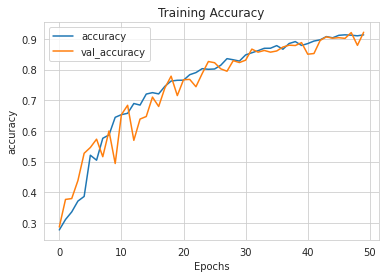

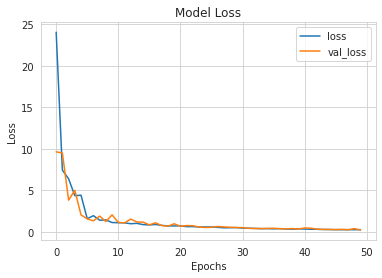

In [32]:
Acc_Loss_Graph(history)

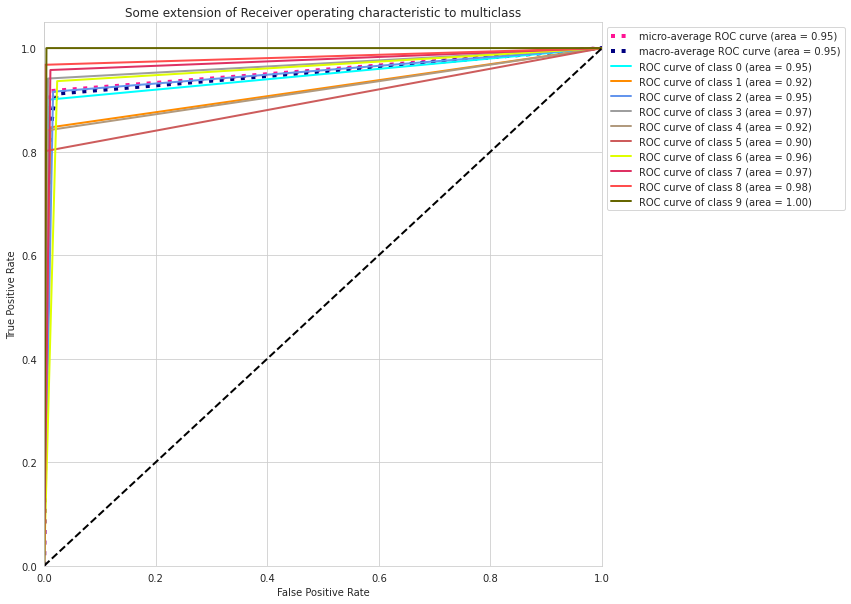

In [33]:
plot_roc_curve(y_test,y_pred2)

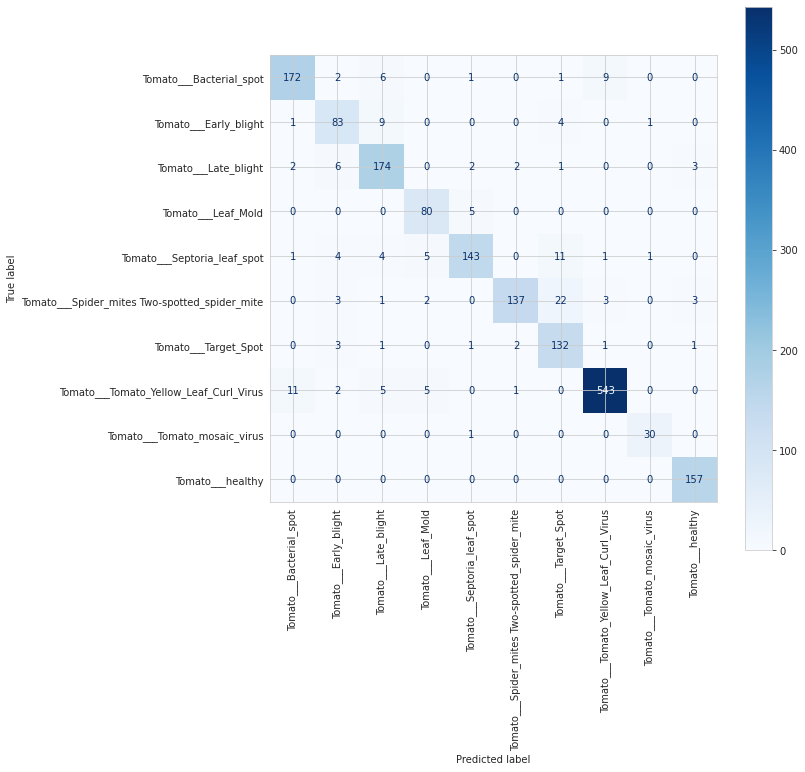

In [34]:
Confusion_Matrix(y_test1 , y_pred1)

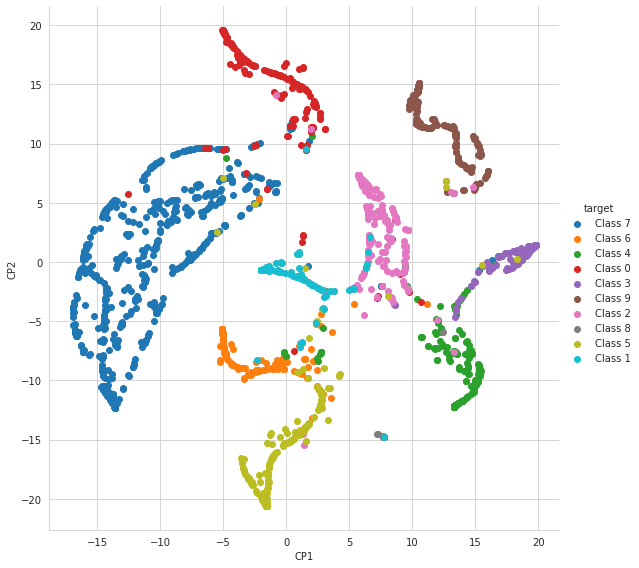

In [35]:
target_name = { 0:'Class 0' ,1:'Class 1',2:'Class 2',3:'Class 3',4:'Class 4',5:'Class 5' , 6:'Class 6' ,7:'Class 7' , 8:'Class 8' ,9:'Class 9'}
from sklearn.manifold import TSNE
tsne1 = TSNE(random_state = 42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(y_pred)
# create dataframe
cps_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((tsne1, 
                                            y_test1)))# cast targets column to int
cps_df.loc[:, 'target'] = cps_df.target.astype(int)
cps_df.loc[:, 'target'] = cps_df.target.map(target_name)
import seaborn as sns
grid = sns.FacetGrid(cps_df, hue="target", height=8)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()